In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd
import math

## Basic Setting

In [2]:
class Config():
    #存放原始图像数据的文件路径
    training_dir = "C:/Users/liu/Desktop/mini-imagenet/"
    testing_dir = "C:/Users/liu/Desktop/Dataset of Siamese Network/testing/"
    target_dir = ""
    train_batch_size = 64
    train_number_epochs = 100

In [3]:
res50 = torchvision.models.resnet50(pretrained=True)

In [4]:
res50.fc.weight.grad_fn

# Modify the model

In [5]:
df = pd.read_csv('C:/Users/liu/Desktop/mini-imagenet/train_tar.csv')
k = list(np.array(df['Unnamed: 2']))
#提取overlap部分
im_100 = res50.fc.weight[k,:]

#删除overlap部分
#weight部分
m = res50.fc.weight[:,:].detach().numpy()
im_900_1 = torch.tensor(np.delete(m,k,axis=0),requires_grad=True)
#bias部分
m = res50.fc.bias[:].detach().numpy()
im_900_2 = torch.tensor(np.delete(m,k,axis=0),requires_grad=True)
#修改最后一层
res50.fc = nn.Linear(2048,100)
#res50.fc.weight[:,:] = Variable(im_900_1)
#res50.fc.bias[:] = Variable(im_900_2)
#增添层
#add_modules = nn.Sequential(nn.ReLU(inplace=True),
                          #nn.Linear(900,100,bias=True))
#res50.add_module(name='add',module=add_modules)

In [29]:
k = pd.DataFrame(im_900_2.detach().numpy())
k.to_csv('C:\\Users\
\liu\\Desktop\\bias.csv')

In [90]:
res50.fc.weight

Parameter containing:
tensor([[-0.0092,  0.0153, -0.0375,  ..., -0.0105,  0.0011, -0.0265],
        [ 0.0104, -0.0266,  0.0005,  ...,  0.0288, -0.0210, -0.0067],
        [-0.0072,  0.0664, -0.0393,  ...,  0.0130, -0.0249, -0.0015],
        ...,
        [-0.0090, -0.0131,  0.0359,  ..., -0.0061, -0.0215,  0.0740],
        [-0.0122,  0.0127,  0.0319,  ...,  0.0495,  0.0040,  0.0221],
        [-0.0215,  0.0239,  0.0809,  ...,  0.0010, -0.0440,  0.0180]],
       grad_fn=<CopySlices>)

In [51]:
print(res50)

None


# Build Data

In [6]:
class MyDataset(Dataset):
    def __init__(self,imageFolderDataset,target_dir,transform=None,should_invert=True):
        #数据集
        self.imageFolderDataset = imageFolderDataset
        #transform 图像预处理的方法
        self.transform = transform
        #是否转化为反色图像
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img = Image.open(self.imageFolderDataset.imgs[index][0])
        if self.should_invert:
            img = PIL.ImageOps.invert(img)

        if self.transform is not None:
            img = self.transform(img)
            
        target = self.imageFolderDataset.imgs[index][0].split('\\')[1][1:9]
        target = math.floor(index/600)
        return img,target
    
    def __len__(self):
        return len(self.imageFolderDataset)

In [7]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)
mydataset = MyDataset(imageFolderDataset=folder_dataset,
                            target_dir=Config.training_dir,
                            transform=transforms.Compose([
                                transforms.Resize((224,224)),
                                transforms.ToTensor()
                                                         ]),
                            should_invert=False)

In [8]:
train_dataloader = DataLoader(mydataset,
                        shuffle=True,
                        #num_workers=8,多线程可根据电脑情况开启或关闭
                        batch_size=Config.train_batch_size#定义batch的大小
                             )

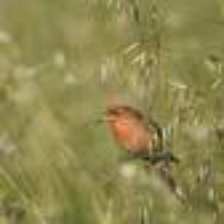

In [9]:
k = Image.open(folder_dataset.imgs[0][0])
c = transforms.Resize((224,224))
c(k)

In [10]:
net = res50
#optimizer = optim.SGD(params=[net.fc.weight],lr = 0.0005)
# 冻结前面layer的自动求导，因为多数的参数不需要计算梯度
for para in list(net.parameters())[:-2]:
    para.requires_grad=False 
optimizer = optim.SGD(params=net.fc.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()
#net.fc.weight[:] = list(net.fc.parameters())[0].detach()
#net.fc.bias[:] = list(net.fc.parameters())[1].detach()

In [11]:
counter = []
loss_history = [] 
iteration_number= 0

In [12]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img,label = data
        optimizer.zero_grad()
        #前项传播
        output = net.forward(img)
        #计算损失函数
        loss_contrastive = criterion(output,label)
        #反向传播
        loss_contrastive.backward()
        #ASGD优化
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)



Epoch number 0
 Current loss 4.722222328186035

Epoch number 0
 Current loss 4.634907245635986

Epoch number 0
 Current loss 4.7016401290893555

Epoch number 0
 Current loss 4.693936347961426

Epoch number 0
 Current loss 4.618170738220215

Epoch number 0
 Current loss 4.697861194610596

Epoch number 0
 Current loss 4.661467552185059

Epoch number 0
 Current loss 4.590023994445801

Epoch number 0
 Current loss 4.615901947021484

Epoch number 0
 Current loss 4.592257976531982

Epoch number 0
 Current loss 4.545132637023926

Epoch number 0
 Current loss 4.57051420211792

Epoch number 0
 Current loss 4.59770393371582

Epoch number 0
 Current loss 4.550945281982422

Epoch number 0
 Current loss 4.604783058166504

Epoch number 0
 Current loss 4.565537929534912

Epoch number 0
 Current loss 4.517245292663574

Epoch number 0
 Current loss 4.547832489013672

Epoch number 0
 Current loss 4.561328887939453

Epoch number 0
 Current loss 4.516843795776367

Epoch number 0
 Current loss 4.5672283172

KeyboardInterrupt: 

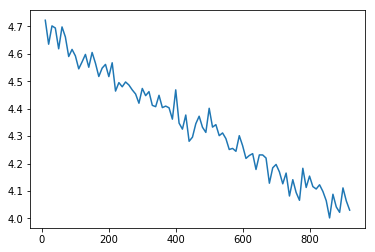

In [22]:
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()
    
show_plot(counter[0:-7],loss_history[0:-7])
